In [1]:
import os
import random
import re

import matplotlib.patches as mpathes
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = ['DejaVu Sans']
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import ticker
from numba import jit
from PqiDataSdk import PqiDataSdk
from tqdm import tqdm

ds = PqiDataSdk(user="zyding", size=64, pool_type="mt")

import sys

sys.path.append('../tools/')

import backtest_cdb_large as bcl
# from backtest_cdb import *

In [2]:
class Config:
    # 用户名 - str
    user = 'zyding'
    # 票池 - 可以填list['000001', '000002'] / 指数代号'000852' / 自定义票池'xxx.csv'
    # 注意使用自定义票池的时候start_date和end_date要与配置里一致。
    # 自定义票池的数据形式为：index为ticker，column为date，值为1或nan的2d dataframe
    tickers = 'all'
    # 拉取数据的进程数，如果要使用接口批量测因子，这里要写为1，如果不填默认是12
    size = 12
    # 拉取数据最早日期，可以早于start_date
    earliest_date = '20170101'
    # 回测起止日期 - str
    start_date = '20180101'
    end_date = '20210331'
    # 全部参考指数 - 可以把想看的指数全部填在indexs的list中
    indexs = ['000852', '000905', '000300']
    # 看超额基准指数 - summary图中alpha_rtn的基准指数，如果填'mean'则benchmark为票池平均return，填指定指数则benchmark为指数收益
    benchmark_index = 'zz1800_mean'
    # 费率 - 换手手续费
    fee_rate = 0.0013
    # return的计算方式 - 'Open2Open' / 'Close2Close' / 'TwapOpen2TwapOpen' / 'TwapClose2TwapClose' 注意大小写以及中间的2
    # 选择 TwapOpen2TwapOpen / TwapClose2TwapClose 的 rtn_type 回测start_date不能早于20150101
    rtn_type = 'TwapOpen2TwapOpen'
    # 分组数
    group_num = 20
    # 正常回测写normal，如果有从文件中读dataframe的需求这里写“exist_df”
    mode = 'normal'
    # 添加按头组数目分多空分组，填'mean'则是按因子值均值分两组，填整数则为指定多空组票数，如果填一个小于1的浮点数则是按比例入选多空分组
    long_short_type = 400
    # long_short_type='0.9'
    # 多空组内持仓比例方式，'factor_value'-因子值加权；'equal'-组内等权
    weight_type = 'factor_value'

plot_config={'fig_width': 20, 'fig_height': 20, 'sample_interval': 30}
cfg = Config()

In [5]:
tickers = ds.get_ticker_list(date='all')
start_date = '20170101'
end_date = '20201231'
lst_trade_date = ds.get_trade_dates(start_date=start_date, end_date=end_date)
DTIndex_trade_date = pd.to_datetime(lst_trade_date).map(lambda x: x.date)

In [6]:
tickers_zz500 = ds.get_index_weight(ticker='000905').StockTicker.values
tickers_zz1000 = ds.get_index_weight(ticker='000852').StockTicker.values
tickers_hs300 = ds.get_index_weight(ticker='399300').StockTicker.values

tickers_zz1800 = np.concatenate([tickers_hs300, tickers_zz500, tickers_zz1000])

In [321]:
eod_stock = ds.get_eod_history(fields=['OpenPrice', 'ClosePrice'],
                              tickers=ds.get_ticker_list(date='all'),
                              start_date='20170101',
                              end_date='20210331',
                              day_type='trade',
                              price_mode='former')

In [322]:
eod_index = ds.get_eod_history(fields=['OpenPrice', 'ClosePrice'],
                               tickers=['000905', '000852', '000001'],
                               source = 'index',
                               start_date='20170101',
                               end_date='20210331',
                               day_type='trade')

In [323]:
df_ret_stock_eod = eod_stock['ClosePrice']/eod_stock['ClosePrice'].shift(axis=1) - 1
df_ret_index_eod = eod_index['ClosePrice']/eod_index['ClosePrice'].shift(axis=1) - 1
df_ret_eod = (eod_stock['OpenPrice']/eod_stock['OpenPrice'].shift(axis=1) - 1).shift(-2, axis=1).stack(dropna=False)

In [324]:
def save_factor(name,
                df_factor,
                path='/home/zyding/factor_zyding/eod_datayes',
                feature_type='eod',
                save_method='update'):
    ds.save_eod_feature(data={name: df_factor},
                        where=path,
                        feature_type=feature_type,
                        save_method=save_method,
                        encrypt=False)

In [11]:
def format_factor(df_factor):
    try:
        df_factor.columns = df_factor.columns.map(
            lambda x: x.strftime('%Y%m%d'))
    except:
        pass
    df_factor.columns.name = None
    df_factor.index.name = None

In [12]:
def calc_ic(df_factor, df_ret_eod=df_ret_eod, plot=False):
    # format_factor(df_factor)
    df_ic = df_factor.corrwith(df_ret_eod)
    df_rank_ic = df_factor.corrwith(df_ret_eod, method='spearman')
    if plot:
        plt.figure(figsize=(20, 5))
        df_ic.plot(label='IC')
        df_rank_ic.plot(label='rank IC')
        plt.grid()
        plt.legend()
    return (round(df_ic.mean(), 5), round(df_rank_ic.mean(), 5))

In [604]:
eod_temp = ds.get_eod_history(fields=['OpenPrice', 'ClosePrice', 'HighestPrice', 'LowestPrice', 'TradeValue', 'TradeVolume', 'TurnoverRate'],
                              tickers=ds.get_ticker_list(date='all'),
                              start_date='20180101',
                              end_date='20210331',
                              day_type='trade',
                              price_mode='former')

In [325]:
eod_all = ds.get_eod_history(fields=['OpenPrice', 'ClosePrice', 'HighestPrice', 'LowestPrice', 'TradeValue', 'TradeVolume', 'TurnoverRate'],
                              tickers=ds.get_ticker_list(date='all'),
                              start_date='20180101',
                              end_date='20210331',
                              day_type='trade',
                              price_mode='former')

In [405]:
tickers_zz1000_eod = ds.get_index_weight(ticker='000852',
                                         start_date='20180101',
                                         end_date='20210331',
                                         format='eod')
tickers_zz1000_eod = tickers_zz1000_eod / tickers_zz1000_eod
tickers_zz500_eod = ds.get_index_weight(ticker='000905',
                                        start_date='20180101',
                                        end_date='20210331',
                                        format='eod')
tickers_zz500_eod = tickers_zz500_eod / tickers_zz500_eod
tickers_hs300_eod = ds.get_index_weight(ticker='399300',
                                        start_date='20180101',
                                        end_date='20210331',
                                        format='eod')
tickers_hs300_eod = tickers_hs300_eod / tickers_hs300_eod

tickers_zz1800_eod = (tickers_hs300_eod.replace(np.nan, 0) +
                      tickers_zz500_eod.replace(np.nan, 0) +
                      tickers_zz1000_eod.replace(np.nan, 0)).replace(0, np.nan)

In [418]:
%%time
eod_stacked = pd.DataFrame(index=eod_all['OpenPrice'].stack(dropna=False).index, columns=eod_all.keys())
for key in eod_all.keys():
    eod_stacked[key] = eod_all[key].stack()

CPU times: user 34.3 s, sys: 2.88 s, total: 37.2 s
Wall time: 37.2 s


In [420]:
eod_stacked_copy = eod_stacked.copy(deep=True)

In [637]:
eod_stacked = eod_stacked_copy.copy(deep=True)

In [638]:
eod_stacked = eod_stacked[eod_stacked.index.isin(tickers_zz1000_eod.stack().index)]

In [639]:
for column in ['ClosePrice', 'HighestPrice', 'TradeVolume']:
    eod_stacked[column] = eod_stacked[column].unstack().rank(pct=True).stack()

In [640]:
def get_PVcorr(price='ClosePrice', window=10):
    PVcorr = eod_stacked[[price,'TradeVolume']].reset_index().groupby('level_0')[[price,'TradeVolume']].rolling(window).corr()
    return PVcorr

In [641]:
%%time
for price in ('ClosePrice', ):
    for window in (3, 5, 10):
        eod_stacked[f'PVcorr_{price[0]}_{window}'] = get_PVcorr(price, window).loc[:, :, price]['TradeVolume'].values

CPU times: user 1min 5s, sys: 191 ms, total: 1min 5s
Wall time: 1min 5s


In [642]:
for price in ('ClosePrice', ):
    for window in (3, 5, 10):
        eod_stacked[f'PVcorr_{price[0]}_{window}'] = eod_stacked[f'PVcorr_{price[0]}_{window}'].unstack().rank(pct=True).stack()

In [643]:
dict_temp = {}
for price in ('ClosePrice', ):
    for window in (3, 5, 10):
        dict_temp[f'factor_PVcorr_{price[0]}_{window}'] = eod_stacked[f'PVcorr_{price[0]}_{window}'].unstack().replace([-np.inf, np.inf], np.nan)

In [ ]:
eod_ret_close = eod_all['ClosePrice']/eod_all['ClosePrice'].shift(axis=1)-1

eod_ret_close = eod_ret_close * tickers_zz1000_eod

for n in (3, 5, 10):
    eod_stacked[f'RetDiff_{n}'] = (eod_ret_close-eod_ret_close.shift(n, axis=1)).rank(pct=True).stack(dropna=False)

dict_temp = {}
for price in ('ClosePrice', 'HighestPrice'):
    for window in (10, 15):
        for n in (3, 5, 10):
            eod_stacked[f'factor_PVcorr_{price[0]}{window}_{n}'] = - eod_stacked[f'PVcorr_{price[0]}_{window}'] * eod_stacked[f'RetDiff_{n}']
            dict_temp[f'factor_PVcorr_{price[0]}{window}_{n}'] = eod_stacked[f'factor_PVcorr_{price[0]}{window}_{n}'].unstack().replace([-np.inf, np.inf], np.nan)

In [644]:
for i in dict_temp.keys():
    print(i, 'rol', calc_ic(dict_temp[i].rolling(5, axis=1).mean()))
    print(i, 'ewm', calc_ic(dict_temp[i].ewm(5, axis=1).mean()))

factor_PVcorr_C_3 rol (-0.006461870234798017, -0.023408639204999675)
factor_PVcorr_C_3 ewm (-0.006630810017313805, -0.023862811761992227)
factor_PVcorr_C_5 rol (-0.007266028030255023, -0.023962260602796867)
factor_PVcorr_C_5 ewm (-0.007570699820036512, -0.024620661070647153)
factor_PVcorr_C_10 rol (-0.008306932787397529, -0.024166256891328446)
factor_PVcorr_C_10 ewm (-0.007832226359204362, -0.023022423477813553)


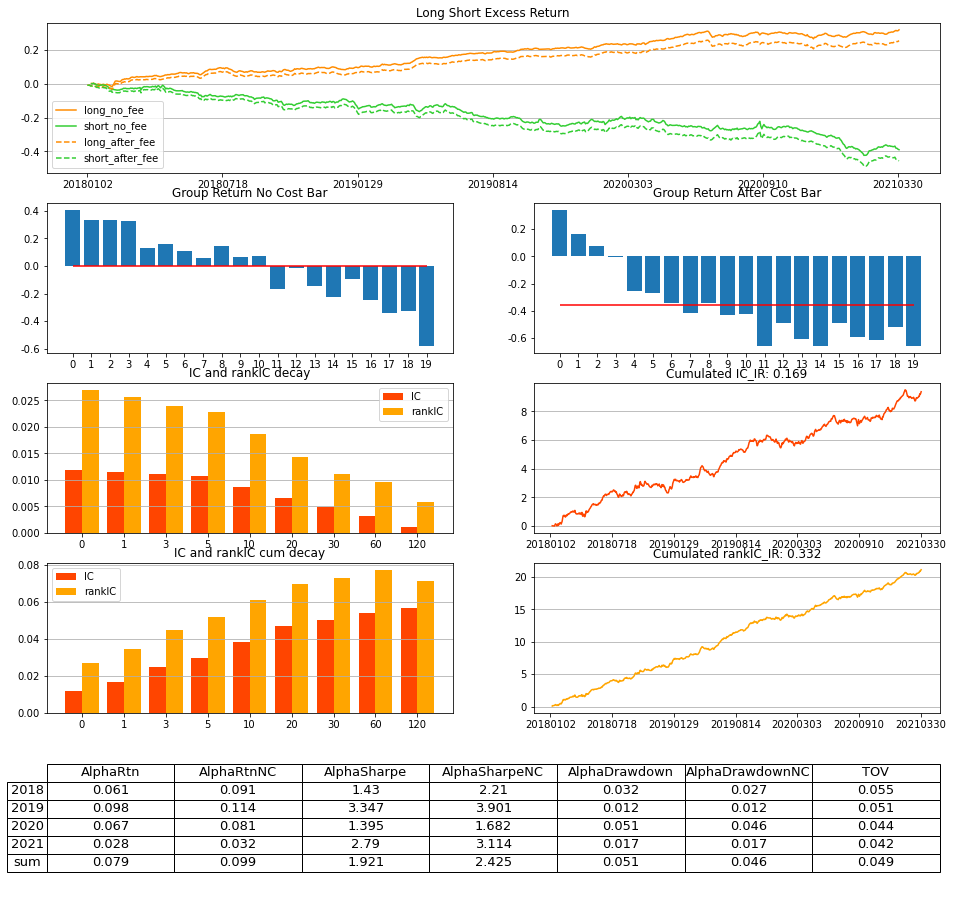

In [657]:
bcl.backtest_bycdb(-dict_temp['factor_PVcorr_C_5'].ewm(5,axis=1).mean().ewm(10, axis=1).mean(), cfg);

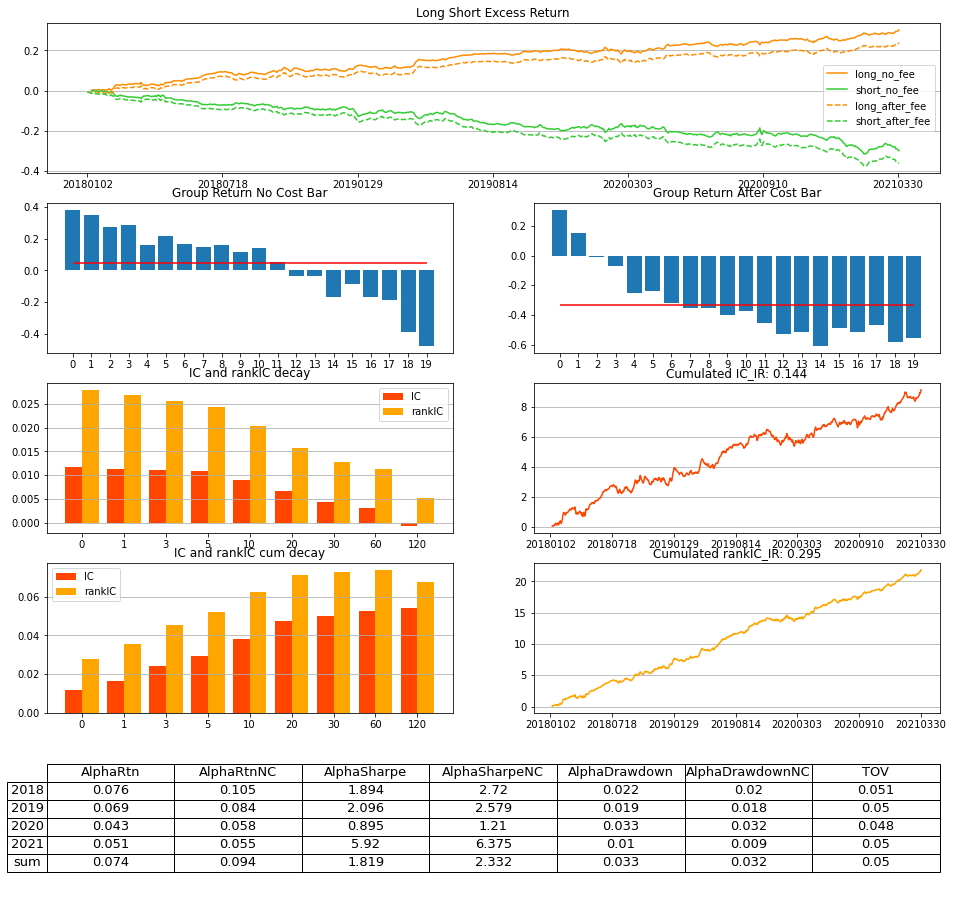

In [577]:
bcl.backtest_bycdb(-dict_temp['factor_PVcorr_C_5'].ewm(5,axis=1).mean().ewm(10, axis=1).mean(), cfg);